# Steps Analysis (02/17/17 - 10/24/18)

In [135]:
from main_clean_function import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
df = main_clean_function('./data/export.xml')

/home/guess/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [138]:
df.head()

,start_date,start_time,end_date,end_time,num_steps,duration,source,steps_per_hour
0,2017-02-17,21.390000,2017-02-17,21.511667,58.0,0.121667,iPhone,476.712329
1,2017-02-17,21.607778,2017-02-17,21.738611,176.0,0.130833,iPhone,1345.222930
2,2017-02-17,21.738611,2017-02-17,21.864444,44.0,0.125833,iPhone,349.668874
3,2017-02-17,21.876111,2017-02-17,21.976944,18.0,0.100833,iPhone,178.512397
4,2017-02-17,21.976944,2017-02-17,22.126389,215.0,0.149444,iPhone,1438.661710


In [142]:
m_t_p = df.num_steps.max()

In [158]:
print(str(df[df['num_steps'] == m_t_p]['start_date'].values)[2:12])

2018-10-20


In [137]:
print_remainder(df)

Total Rows = 24847
Total Steps = 4093814.0
start_date != end_date: 0


In [89]:
summed_df = df.groupby(by=['start_date', 'end_date']).sum()
summed_df['steps_per_hour'] = summed_df['num_steps']/summed_df['duration']
summed_df.reset_index(inplace=True)

In [90]:
summed_df.tail(60)

,start_date,end_date,start_time,end_time,num_steps,duration,steps_per_hour
554,2018-08-26,2018-08-26,704.251389,728.235556,8354.0,23.984167,348.313123
555,2018-08-27,2018-08-27,543.983333,567.983333,5899.0,24.000000,245.791667
556,2018-08-28,2018-08-28,588.320278,612.320278,5887.0,24.000000,245.291667
557,2018-08-29,2018-08-29,470.688889,494.663611,3722.0,23.974722,155.246846
558,2018-08-30,2018-08-30,407.938056,431.935000,1673.0,23.996944,69.717209
559,2018-08-31,2018-08-31,688.482222,712.482222,6416.0,24.000000,267.333333
560,2018-09-01,2018-09-01,571.798056,595.798056,3694.0,24.000000,153.916667
561,2018-09-02,2018-09-02,660.271667,684.271667,6116.0,24.000000,254.833333
562,2018-09-03,2018-09-03,487.616111,511.616111,4362.0,24.000000,181.750000
563,2018-09-04,2018-09-04,607.649722,631.649722,4441.0,24.000000,185.041667


In [98]:
X = summed_df.start_date.values
y = df.num_steps.values
type(y)

numpy.ndarray

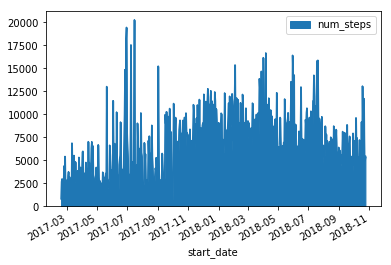

In [107]:
summed_df.plot(x='start_date', y='num_steps', kind='area')

In [115]:
summed_df.min()

start_date        2017-02-17 00:00:00
end_date          2017-02-17 00:00:00
start_time                          0
end_time                           24
num_steps                         612
duration                     0.718056
steps_per_hour                69.7172
dtype: object